# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [171]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier
import time
from warnings import filterwarnings
filterwarnings('ignore')

In [172]:
# Read in data
bank_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [173]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [174]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [175]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

After reading the description of the features, it says regarding the duration column that it "should be discarded if the intention is to have a realistic predictive model". I'm going to remove this column.

In [176]:
# Drop duration column
bank_df = bank_df.drop(columns='duration')

In [177]:
# Change column names with '.' to '_'
bank_df.columns = bank_df.columns.str.lower().str.replace('.', '_')

In [178]:
# Check for missing values
bank_df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


Here we can see that we have no missing data.

In [179]:
bank_df.describe(include='all').round(2).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188.0,NaN,NaN,NaN,40.02,10.42,17.0,32.0,38.0,47.0,98.0
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
bank_df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
17495,40,blue-collar,married,professional.course,no,yes,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
8363,28,student,single,university.degree,unknown,no,no,telephone,jun,tue,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
1604,30,blue-collar,married,basic.4y,no,no,no,telephone,may,fri,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
23860,29,technician,single,professional.course,no,no,no,cellular,aug,fri,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
40114,73,retired,married,basic.4y,no,yes,no,cellular,jul,tue,1,999,0,nonexistent,-1.7,94.215,-40.3,0.835,4991.6,yes
6834,60,retired,divorced,basic.4y,unknown,no,no,telephone,may,wed,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
16043,33,blue-collar,married,basic.9y,no,yes,no,cellular,jul,tue,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
13868,49,retired,single,basic.4y,unknown,no,no,cellular,jul,fri,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
11746,56,retired,divorced,basic.4y,no,yes,no,telephone,jun,fri,15,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
35638,21,blue-collar,single,basic.9y,no,yes,no,cellular,may,mon,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no


In [181]:
bank_df['campaign'].value_counts().sort_index()

,count
campaign,
1,17642
2,10570
3,5341
4,2651
5,1599
6,979
7,629
8,400
9,283


In [182]:
bank_df['pdays'].value_counts().sort_index()

,count
pdays,
0,15
1,26
2,61
3,439
4,118
5,46
6,412
7,60
8,18


In [183]:
bank_df['default'].value_counts()

,count
default,
no,32588
unknown,8597
yes,3


Out of the entire dataset, only 3 people were confirmed to have credit in default. The rest did not or it is unknown. I don't believe this will be of much use to us and I will remove it from the dataset.

In [184]:
bank_df = bank_df.drop(columns='default')

In [185]:
bank_df['loan'].value_counts()

,count
loan,
no,33950
yes,6248
unknown,990


In [186]:
bank_df['housing'].value_counts()

,count
housing,
yes,21576
no,18622
unknown,990


In [187]:
bank_df['y'].value_counts()

,count
y,
no,36548
yes,4640


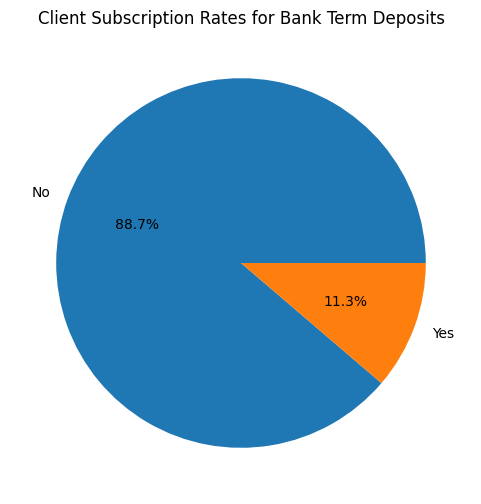

In [188]:
target_values = [bank_df.loc[bank_df['y'] == 'no'].shape[0], bank_df.loc[bank_df['y'] == 'yes'].shape[0]]

plt.figure(figsize=(6, 6))
plt.pie(target_values, labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title("Client Subscription Rates for Bank Term Deposits")
plt.show()

Here we can see that the data for our two classes is very imbalanced.

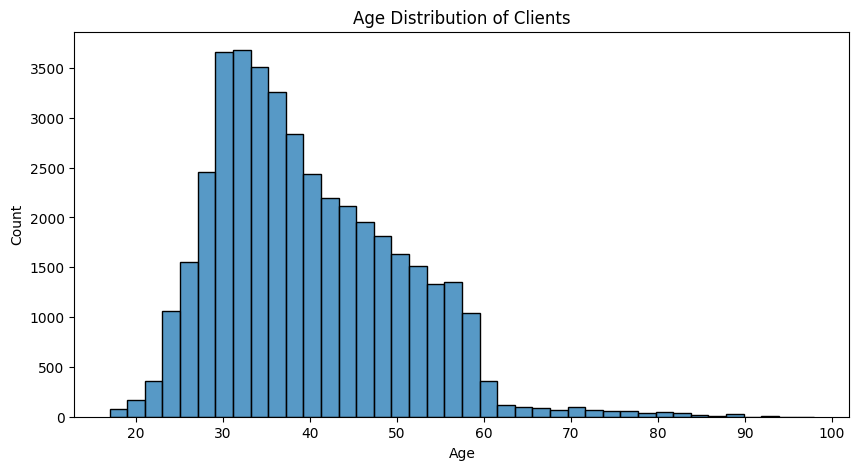

In [189]:
# Plot age distribution
plt.figure(figsize=(10, 5))
sns.histplot(bank_df, x='age', bins=40)
plt.title("Age Distribution of Clients")
plt.xlabel("Age")
plt.show()

<Figure size 1000x500 with 0 Axes>

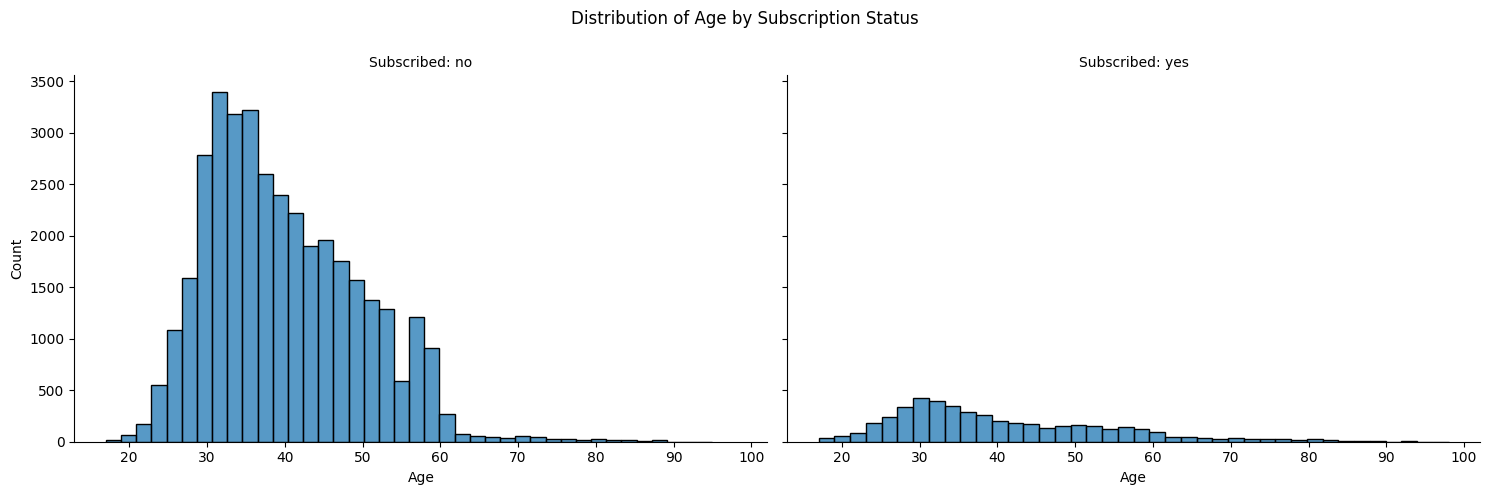

In [190]:
# Plot age distribution by target
plt.figure(figsize=(10, 5))
g = sns.FacetGrid(bank_df, col="y", height=5, aspect=1.5)
g.map(sns.histplot, "age", bins=40, edgecolor='k')
g.set_axis_labels('Age', 'Count')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Age by Subscription Status')
g.set_titles(col_template="Subscribed: {col_name}")
plt.show()

In [191]:
bank_df.loc[bank_df['y'] == 'yes']['age'].value_counts().sort_values(ascending=False)

,count
age,
31,220
33,210
30,202
29,186
34,184
...,...
92,3
17,2
98,2


The highest amount of people who responded 'yes' were those in their late 20's and 30's.

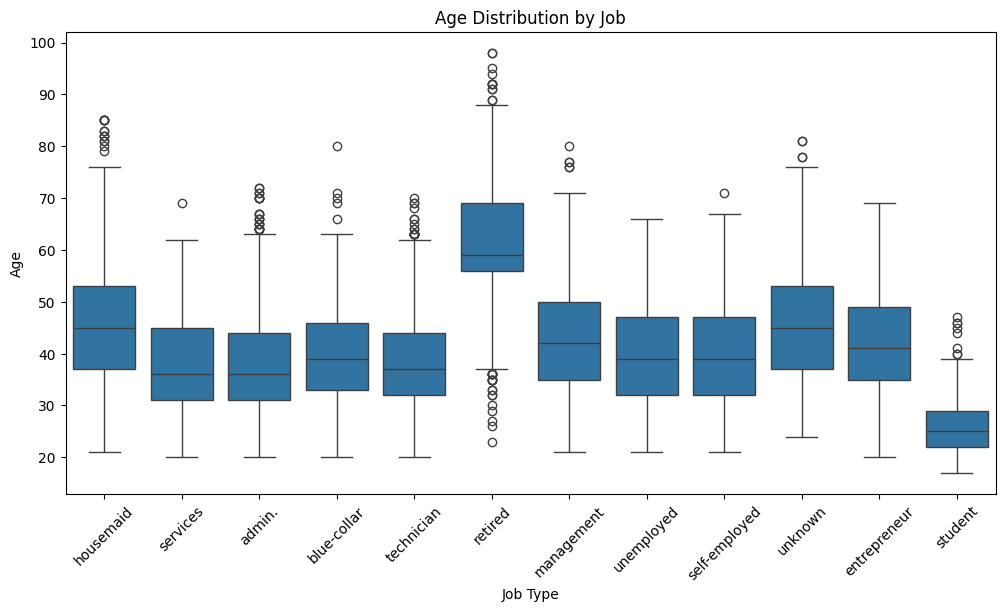

In [192]:
# Box plot for age vs job
plt.figure(figsize=(12, 6))
sns.boxplot(data=bank_df, x='job', y='age')
plt.title('Age Distribution by Job')
plt.xlabel('Job Type')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

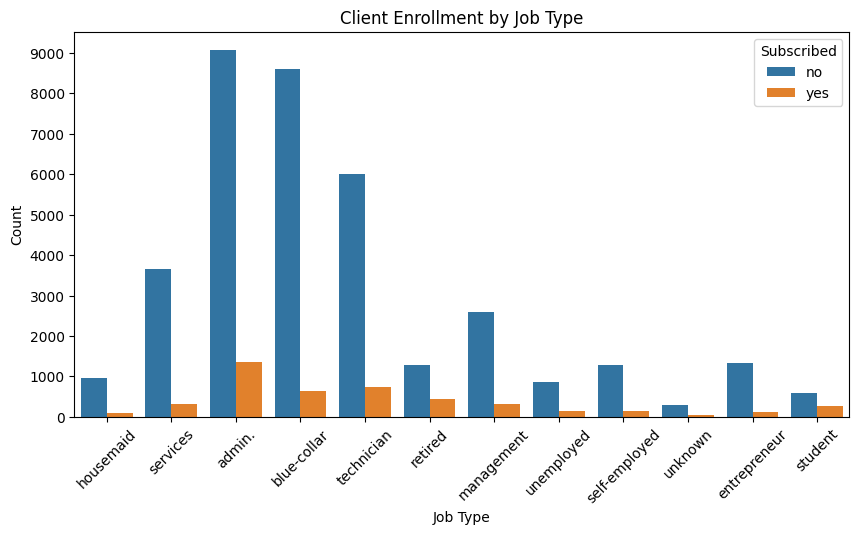

In [193]:
# Plot job type vs target
plt.figure(figsize=(10,5))
sns.countplot(bank_df, x='job', hue='y')
plt.xticks(rotation=45)
plt.title("Client Enrollment by Job Type")
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
plt.legend(title='Subscribed')
plt.show()

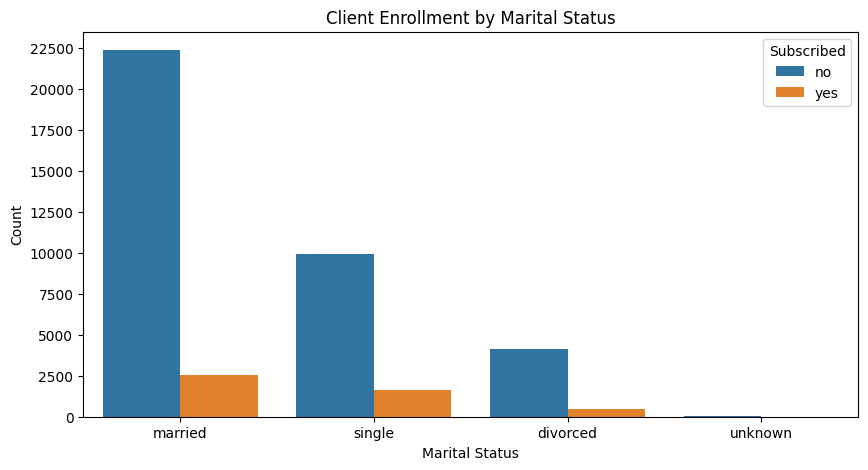

In [194]:
# Plot marital status and target
plt.figure(figsize=(10,5))
sns.countplot(bank_df, x='marital', hue='y')
plt.title("Client Enrollment by Marital Status")
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Subscribed')
plt.yticks([0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500])
plt.show()

In [195]:
# Get percentages of how many people enrolled for each marital status category
married_total_count = bank_df.loc[bank_df['marital'] == 'married'].shape[0]
married_and_yes_count = bank_df.loc[(bank_df['marital'] == 'married') & (bank_df['y'] == 'yes')].shape[0]
married_and_yes_percentage = round((married_and_yes_count / married_total_count) * 100, ndigits=2)

single_total_count = bank_df.loc[bank_df['marital'] == 'single'].shape[0]
single_and_yes_count = bank_df.loc[(bank_df['marital'] == 'single') & (bank_df['y'] == 'yes')].shape[0]
single_and_yes_percentage = round((single_and_yes_count / single_total_count) * 100, ndigits=2)

divorced_total_count = bank_df.loc[bank_df['marital'] == 'divorced'].shape[0]
divorced_and_yes_count = bank_df.loc[(bank_df['marital'] == 'divorced') & (bank_df['y'] == 'yes')].shape[0]
divorced_and_yes_percentage = round((divorced_and_yes_count / divorced_total_count) * 100, ndigits=2)

print("Married subscription %: {}".format(married_and_yes_percentage))
print("Single subscription %: {}".format(single_and_yes_percentage))
print("Divorced subscription %: {}".format(divorced_and_yes_percentage))

Married subscription %: 10.16
Single subscription %: 14.0
Divorced subscription %: 10.32


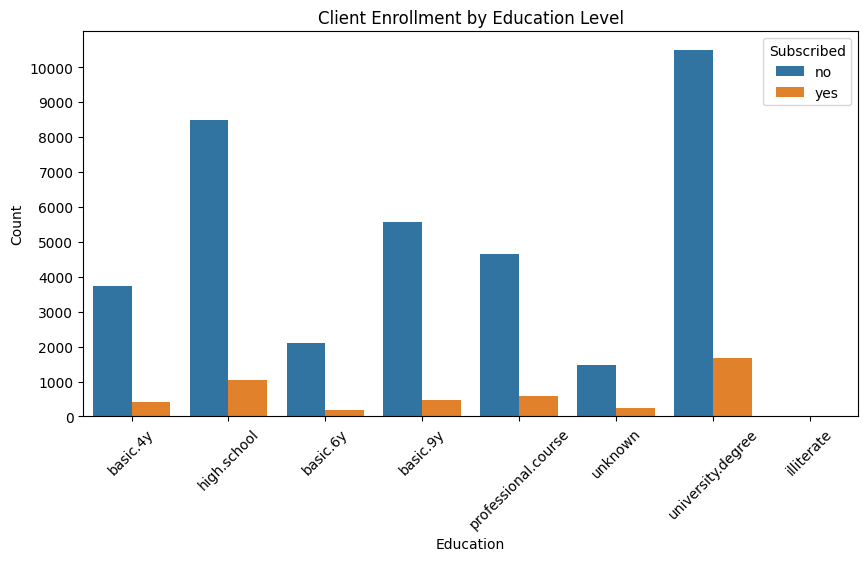

In [196]:
# Plot education and target
plt.figure(figsize=(10,5))
sns.countplot(bank_df, x='education', hue='y')
plt.title("Client Enrollment by Education Level")
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend(title='Subscribed')
plt.xticks(rotation=45)
plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
plt.show()

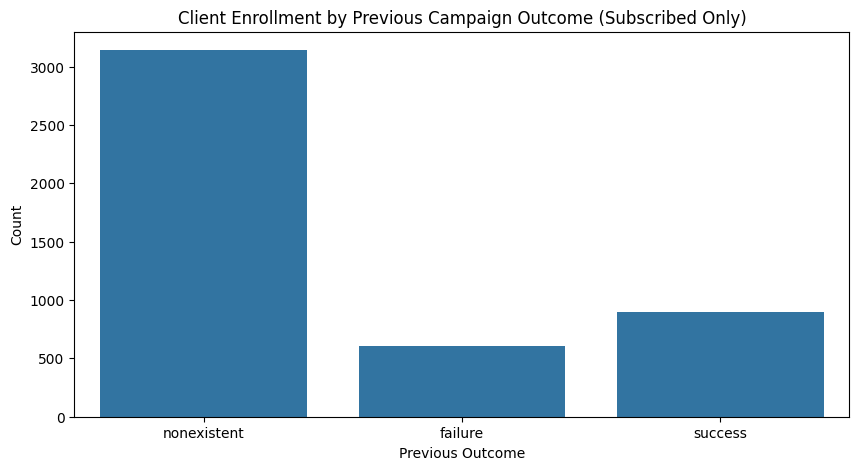

In [197]:
# Plot count of subscribed based off previous outcome
filtered_df = bank_df.loc[bank_df['y'] == 'yes']
plt.figure(figsize=(10,5))
sns.countplot(filtered_df, x='poutcome')
plt.title("Client Enrollment by Previous Campaign Outcome (Subscribed Only)")
plt.xlabel('Previous Outcome')
plt.ylabel('Count')
plt.show()

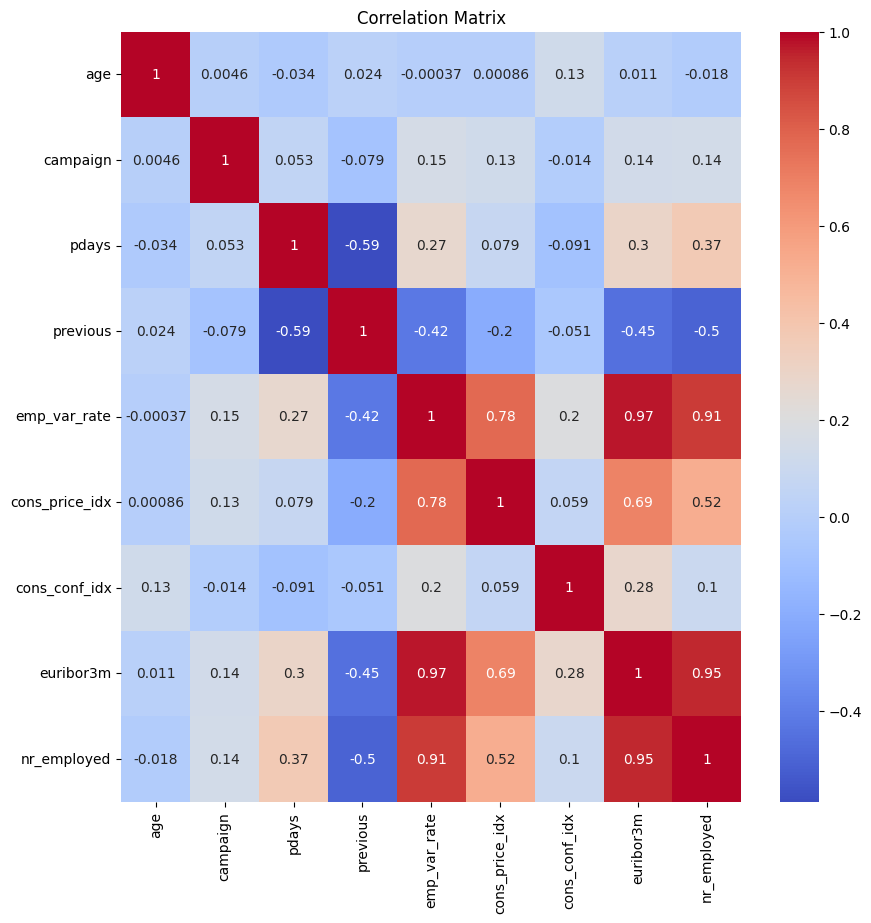

In [198]:
# Plot correlation matrix as heatmap
correlation_matrix = bank_df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

After initial investigation of the data, it's clear that the classes are very imbalanced.

We can see that most of the people that were contacted were in their 20's, 30's and 40's. Of those who did subscribe, most of them were in their late 20's and 30's.

Those who subscribed mostly held administrative jobs followed by technicians and blue-collar workers.

Most subscriptions came from married people, followed those who were single and divorced. However, the highest subscription rate came from those who were single at 14%.

When filtering by education level, the highest amount of subscriptions came from those who hold a university degree.

Lastly, there was higher enrollment from the clients who were never contacted before or subscribed previously (previous successful campaign).

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The primary objective of this task is to develop a model that can accurately predict potential customers who will subscribe to a bank term deposit. The model will use data from bank clients (age, job, marital status, loans), previous interactions (outcome of a previous campaign), and social and economic factors. The business objective is to increase subscription rate for bank term deposits by identifying the most likely candidates.


I believe that given the fact we are trying to identify the most likely candidates, the bank wants to avoid spending time and resources on candidates who are not likely to subscribe. Because of this, I think maximizing precision and reducing false positives will be most important.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [199]:
# Separate training data and target
X = bank_df.drop('y', axis=1)
y = bank_df[['y']]

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [201]:
# Dummy classifier for baseline model
dummy_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='stratified', random_state=42))
])

dummy_pipe.fit(X_train, y_train)

y_pred_dummy = dummy_pipe.predict(X_test)
print("Dummy Classifier Performance:")
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_dummy)))
print("Precision: {}".format(precision_score(y_test, y_pred_dummy)))
print("Recall: {}".format(recall_score(y_test, y_pred_dummy)))
print("F1 Score: {}".format(f1_score(y_test, y_pred_dummy)))

Dummy Classifier Performance:
Accuracy: 0.7994658897790726
Precision: 0.10561056105610561
Recall: 0.10267379679144385
F1 Score: 0.10412147505422993


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [202]:
# Function to train and evaluate models
def train_and_evaluate_model(model, model_name):
    # Preprocessor and model
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit
    pipe.fit(X_train, y_train)

    # Predict on test set
    y_pred = pipe.predict(X_test)

    # Evaluate
    print("MODEL NAME: {}".format(model_name))
    print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {}".format(precision_score(y_test, y_pred)))
    print("Recall: {}".format(recall_score(y_test, y_pred)))
    print("F1 Score: {}".format(f1_score(y_test, y_pred)))


In [203]:
# Default Logistic Regression
lr = LogisticRegression()

train_and_evaluate_model(lr, "Logistic Regression")

MODEL NAME: Logistic Regression
Accuracy: 0.8968196164117505
Precision: 0.6349206349206349
Recall: 0.21390374331550802
F1 Score: 0.32


### Problem 9: Score the Model

What is the accuracy of your model?

MODEL NAME: Logistic Regression

Accuracy: 0.89

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [204]:
# Creating results list
results = []

In [205]:
# Adding train time to the function
def train_and_evaluate_model(model, model_name):
    # Preprocessor and model
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit model and time it
    start_time = time.time()
    pipe.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Predict on training set
    y_train_pred = pipe.predict(X_train)

    # Predict on test set
    y_test_pred = pipe.predict(X_test)

    # Evaluate
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    results.append([model_name, fit_time, train_accuracy, test_accuracy])

In [206]:
log_reg_model = LogisticRegression()
train_and_evaluate_model(log_reg_model, "Logistic Regression")

In [207]:
knn_model = KNeighborsClassifier()
train_and_evaluate_model(knn_model, "K Nearest Neighbors")

In [208]:
decision_tree_model = DecisionTreeClassifier()
train_and_evaluate_model(decision_tree_model, "Decision Tree")

In [209]:
svm_model = SVC()
train_and_evaluate_model(svm_model, "Support Vector Machine")

In [210]:
results_df = pd.DataFrame(results, columns=['Model', 'Fit Time', 'Train Accuracy', 'Test Accuracy'])
results_df.set_index('Model', inplace=True)
results_df

,Fit Time,Train Accuracy,Test Accuracy
Model,,,
Logistic Regression,0.725483,0.901244,0.896820
K Nearest Neighbors,0.223510,0.913991,0.892692
Decision Tree,0.489728,0.995023,0.837582
Support Vector Machine,198.323265,0.905432,0.896941


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [211]:
results = []

In [212]:
# Changing function to use GridSearch and SFS
def train_and_evaluate_model(model, model_name, params, n_features_to_select):

    # RFE Feature Selection
    sfs = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select, direction='forward', cv=2)

    # Preprocessor and model
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', sfs),
        ('model', model)
    ])

    grid_search = GridSearchCV(pipe, param_grid=params, cv=2, scoring='f1', n_jobs=-1, verbose=3)

    # Fit model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Best estimator
    best_model = grid_search.best_estimator_

    # Predict on training set
    y_train_pred = best_model.predict(X_train)

    # Predict on test set
    y_test_pred = best_model.predict(X_test)

    # Evaluate
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Append results
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'Fit Time': fit_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

In [213]:
# Logistic regression param grid
log_reg_param_grid = {
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.1, 1, 10]
}

In [214]:
# KNN param grid
knn_param_grid = {
    'model__n_neighbors': [3, 5, 7]
}

In [215]:
# Decision tree param grid
dt_param_grid = {
    'model__max_depth': [5, 10, 15]
}

In [221]:
# SVM param grid
svm_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear']
}

In [217]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
train_and_evaluate_model(log_reg, 'Logistic Regression', log_reg_param_grid, n_features_to_select=5)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [218]:
# K Nearest Neighbors
knn = KNeighborsClassifier()
train_and_evaluate_model(knn, 'K Nearest Neighbors', knn_param_grid, n_features_to_select=5)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [219]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
train_and_evaluate_model(decision_tree, 'Decision Tree', dt_param_grid, n_features_to_select=5)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [222]:
# Support Vector Machine
svm_model = SVC()
train_and_evaluate_model(svm_model, 'Support Vector Machine', svm_param_grid, n_features_to_select=5)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [223]:
results_5_feature_df = pd.DataFrame(results)
results_5_feature_df

,Model,Best Params,Fit Time,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,"{'model__C': 0.1, 'model__penalty': 'l2'}",93.635900,0.900121,0.897062,0.671937,0.181818,0.286195
1,K Nearest Neighbors,{'model__n_neighbors': 5},2788.145217,0.900182,0.890022,0.536896,0.225668,0.317771
2,Decision Tree,{'model__max_depth': 10},28.965585,0.902519,0.897305,0.627507,0.234225,0.341121
3,Support Vector Machine,"{'model__C': 0.1, 'model__kernel': 'linear'}",7279.808355,0.898209,0.894756,0.608974,0.203209,0.304731
